In [219]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset



from utilities.dataset import distribution_data_sampler
from utilities import constants

import scipy.stats as stats

from utilities.custom_layers import BaseEncoder, BaseDecoder


n_samples = 10000
# import scienceplots

# plt.style.use('science')

In [220]:
# fig, ax = plt.subplots(len(x_array), len(y_array), figsize=(16, 9))
# fig.tight_layout()


# activation = activation=keras.activations.relu


# for idx, x_name in enumerate(x_array):
#     for idy, y_name in enumerate(y_array):
#         cur_x, cur_y = eval(x_name), eval(y_name)
        

#         for name_transformation, func_transformation in tranformations.items():
#             transformed_x = func_transformation(cur_x)
#             try:
#                 model = MLP(transformed_x.shape[1], 1, 1024, depth=2, activation=activation)
#                 model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
#                 model.fit(transformed_x, cur_y, epochs=1000, verbose=0)
#                 y_hat = model.predict(transformed_x)
#                 score = mse(y_hat, cur_y)
#                 print(f"{score} : {name_transformation}")
#                 ax[idx, idy].plot(cur_x, y_hat, '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : {name_transformation}')
#             except:
#                 print(name_transformation, 'NANS')


#         ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

#         ax[idx, idy].set_title(f'{x_name}/{y_name}')
#         ax[idx, idy].legend()
# plt.suptitle('MLP', y=1.02)
# plt.show(

In [221]:
with open("best_params.pkl", "rb") as file:
    data = pickle.load(file)

for idx, inp in enumerate(data):
    data[idx]['history'] = np.pad(np.array(inp['history']), (0, 1000 - len(inp['history'])), 'edge') 
    
df = pd.json_normalize(data)

In [222]:
xy_arrays = df.groupby(['x', 'y']).size().index.to_list()

In [223]:
xy_arrays

[('norm', 'exp'), ('norm', 'lin')]

In [224]:
# base_array = [2, 3, 4, 8, 16, 32]
base_array = [2, 3, 4]

font_size_sublabels = 15
dist_names = {'norm': f'N({constants.NORM_LOC}, {constants.NORM_SCALE})',
              'lognorm': f'LN({constants.EXPON_LOC}, {constants.EXPON_SCALE}, {constants.EXPON_S})'}

y_funcs = {
    'exp' : f'y = exp(X) + N(0, 1)',
    'lin' :  f'y = lin(X) + N(0, 1)'
}
params = np.array(['norm', 'keep_origin'])
slice_from = 0
func = np.log2

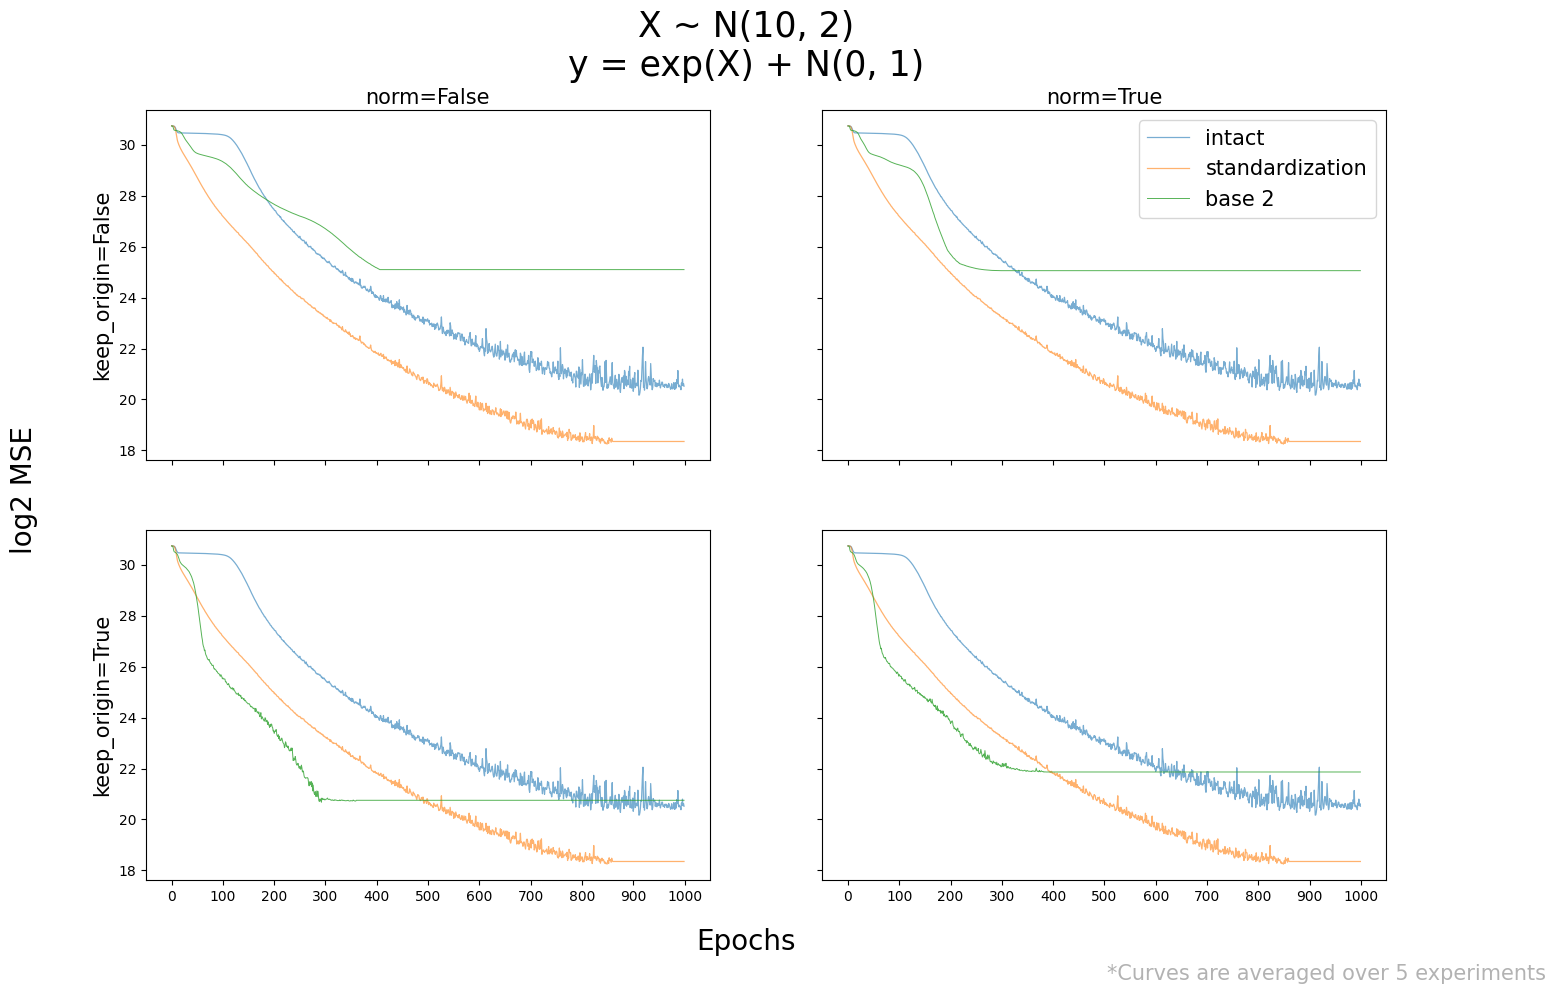

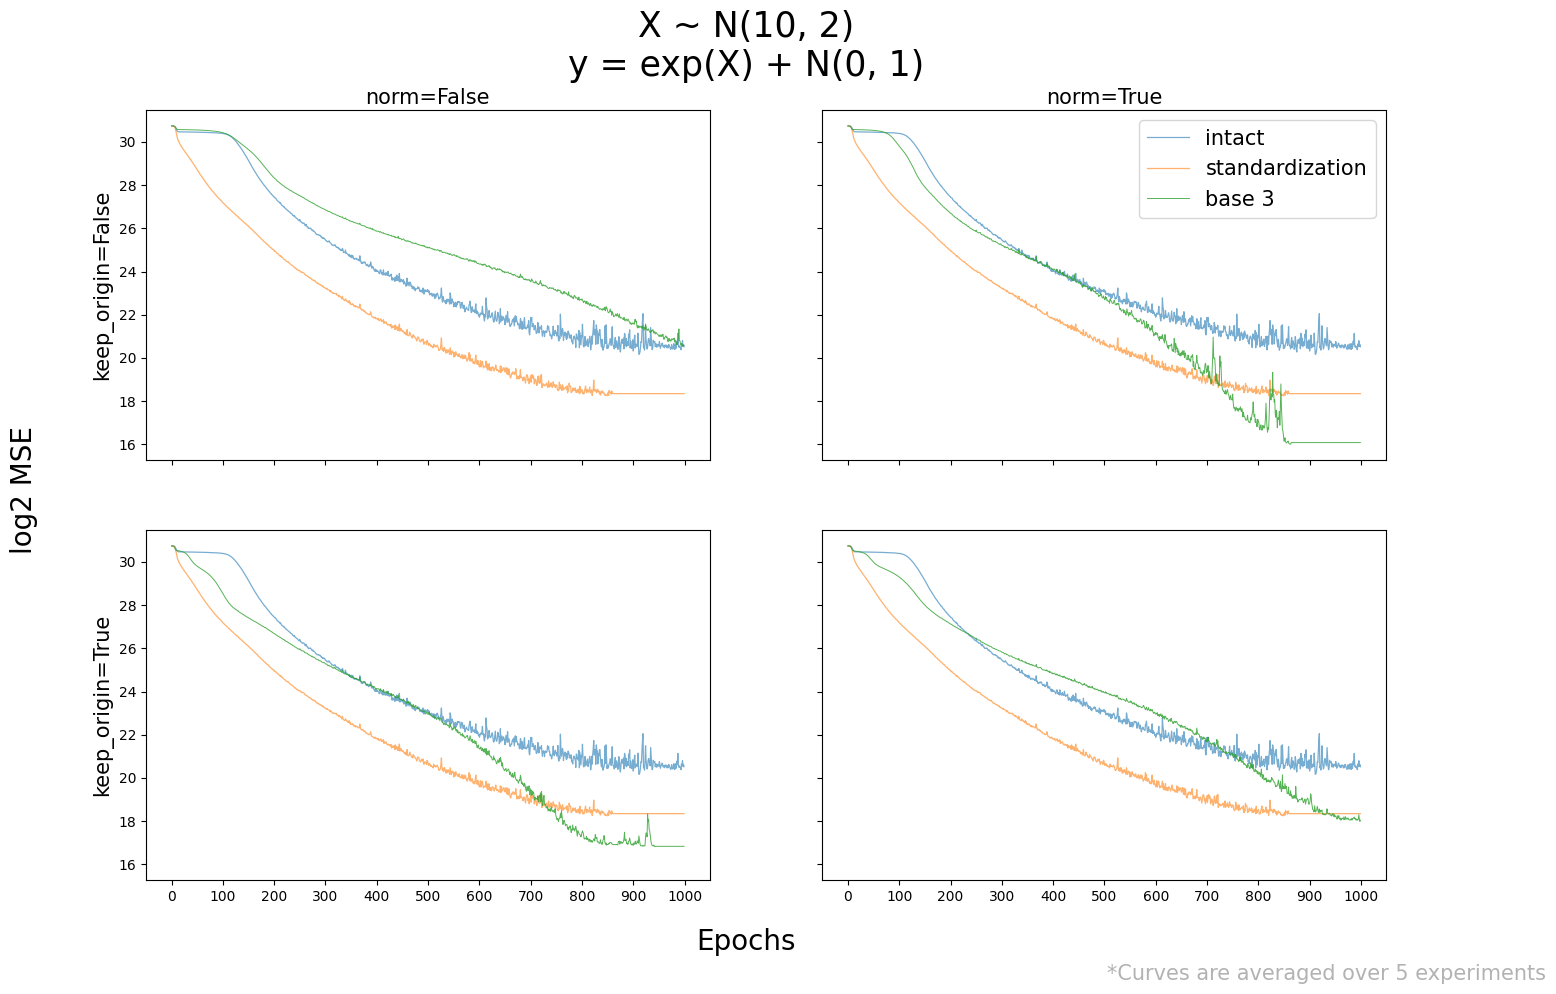

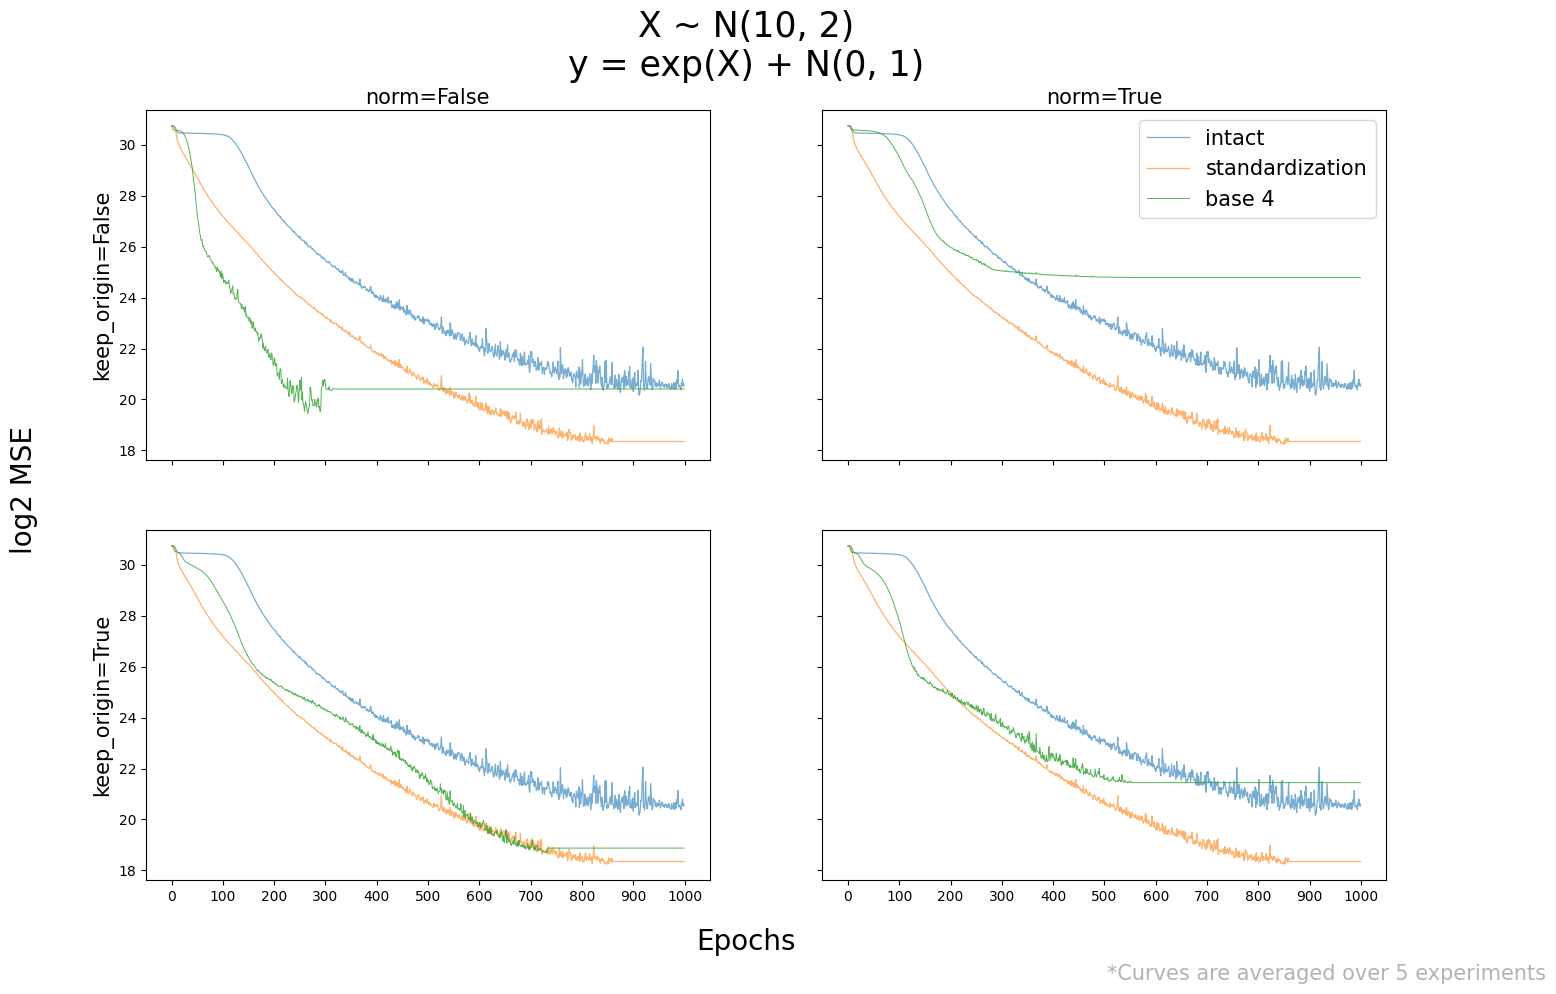

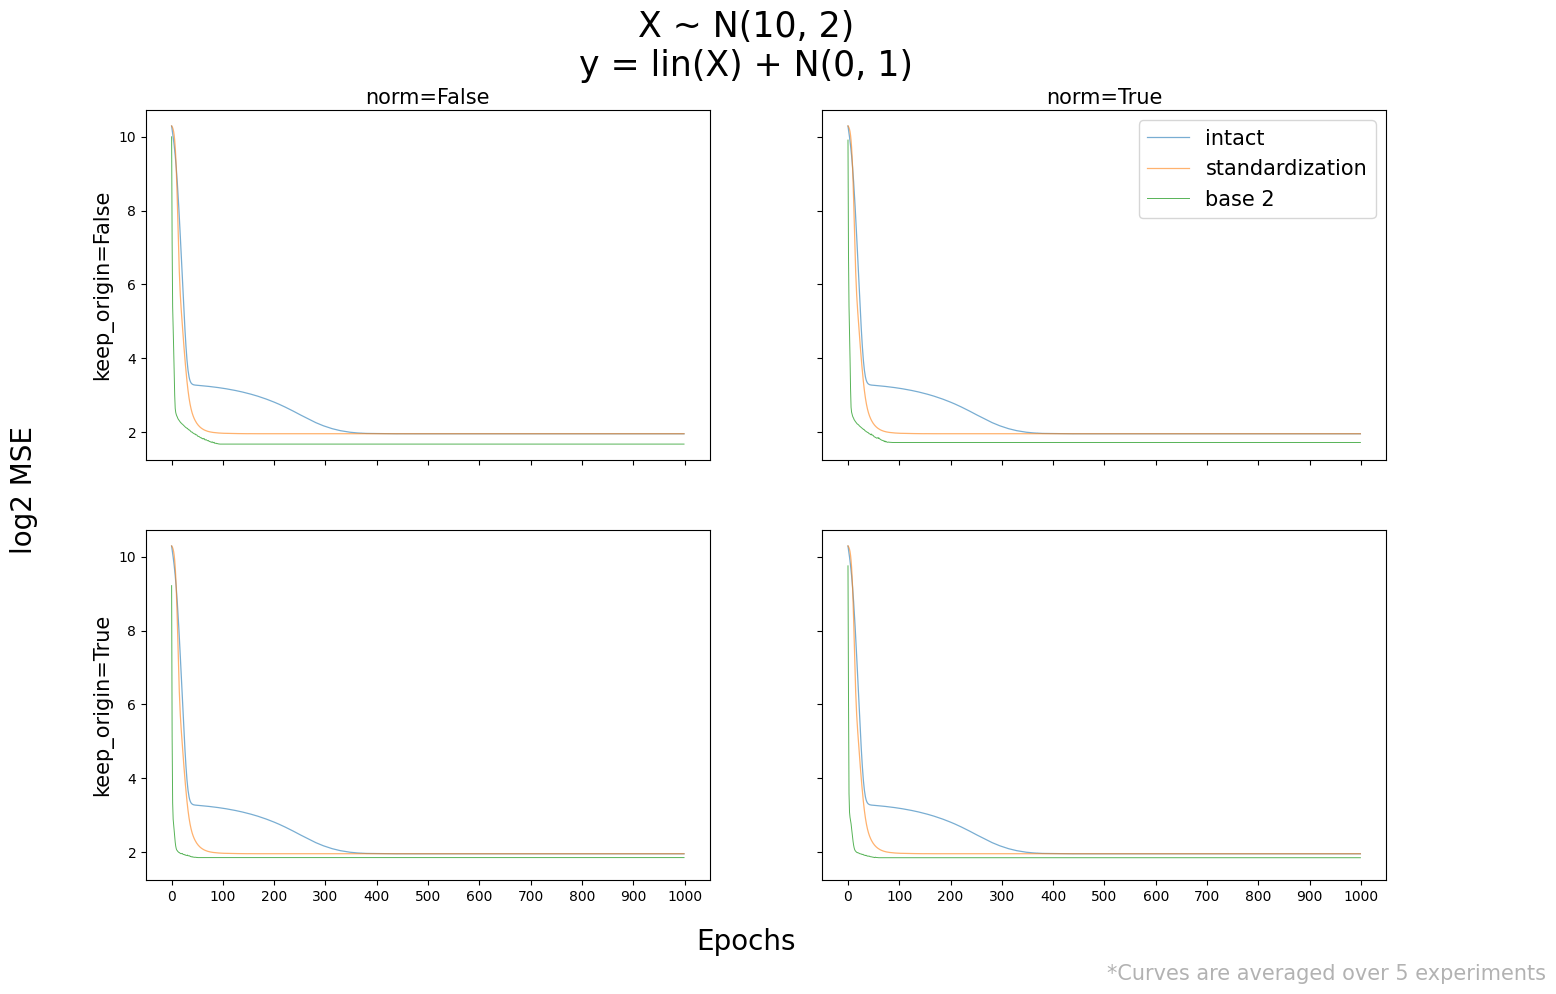

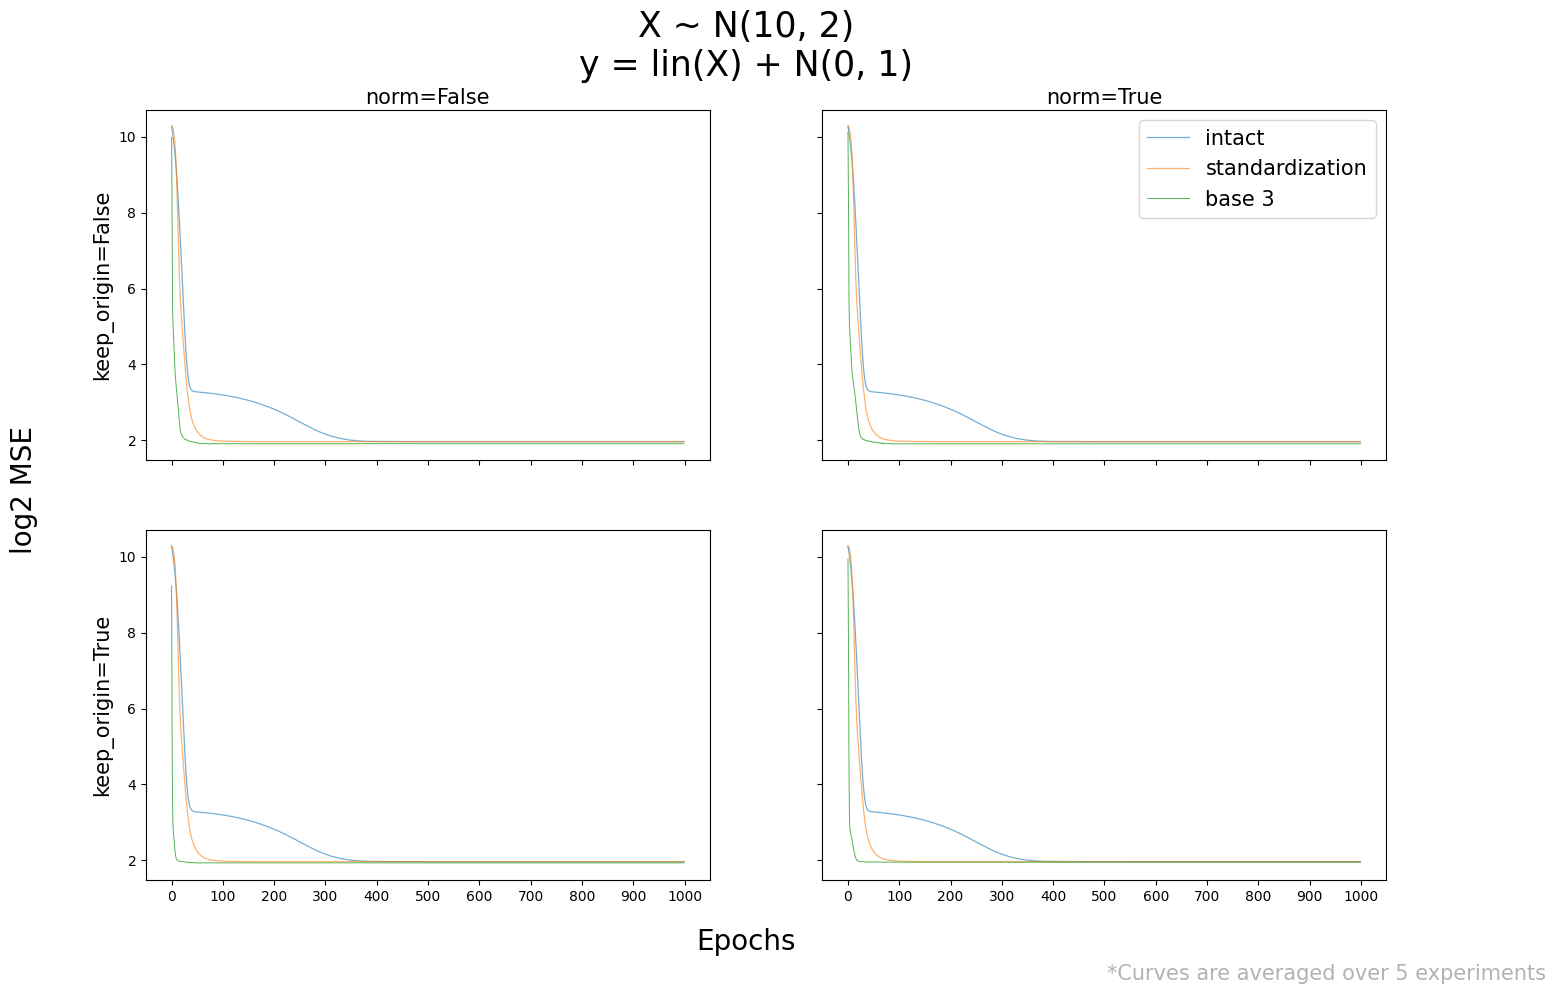

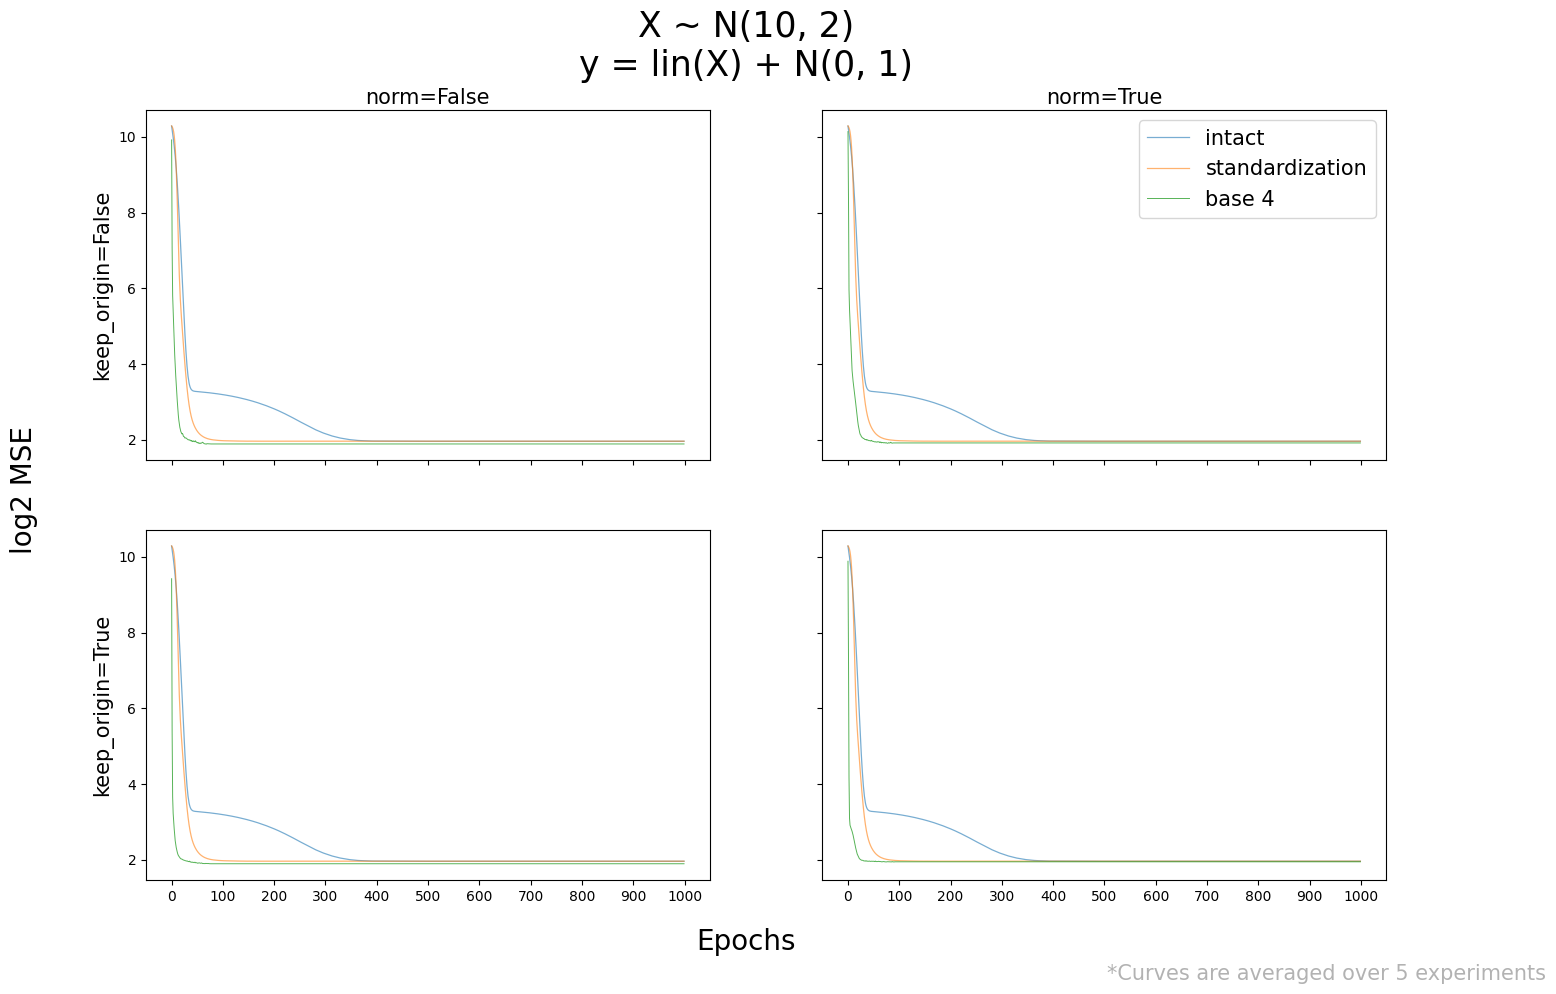

In [225]:
for x, y in xy_arrays:
    for base in base_array:
        if x == 'norm' and y =='norm':
            continue
        mask = (df['x']==x)&(df['y']==y)
        ne = df[mask&(df['transformation_params.base']==base)]
        intact = np.array(df[mask&(df['transformation_name']=="intact")]["history"].to_list())
        standardization = np.array(df[mask&(df['transformation_name']=="standardization")&(df['transformation_params.keep_origin']==False)]["history"].to_list())
        standardization_and_intact = np.array(df[mask&(df['transformation_name']=="standardization")&(df['transformation_params.keep_origin']==True)]["history"].to_list())
        baselines = {'intact':intact, 'standardization':standardization} 


        linewidth = 0.9
        fig, ax = plt.subplots(2, 2, figsize=(16,10), sharex=True, sharey=True)
        for idy, keep_origin in enumerate([False, True]):
            for idx, norm in enumerate([False, True]):
                for loss_name, loss in baselines.items():
                    ax[idy, idx].plot(func(loss.mean(axis=0))[slice_from:], label=loss_name, alpha=0.6, linewidth=linewidth)
                loss = func(np.array(ne[(ne[f'transformation_params.keep_origin']==keep_origin)&(ne[f'transformation_params.norm']==norm)]['history'].to_list()).mean(axis=0)[slice_from:])
                ax[idy, idx].plot(loss, '-', linewidth=linewidth-0.2, alpha=0.8, label=f'base {base}')
                xticks = list(range(0, len(loss_0)+1, 100))
                ax[idy, idx].set_xticks(xticks, labels=list(range(slice_from, len(loss_0)+slice_from+1, 100)))

        plt.suptitle(f'X ~ {dist_names[x]}\n{y_funcs[y]}', size=25)
        ax[0, 0].set_ylabel(f"keep_origin=False", size=font_size_sublabels)
        ax[1, 0].set_ylabel(f"keep_origin=True", size=font_size_sublabels)
        ax[0, 0].xaxis.set_label_position('top')
        ax[0, 1].xaxis.set_label_position('top')

        ax[0, 0].set_xlabel(f"norm=False", size=font_size_sublabels)
        ax[0, 1].set_xlabel(f"norm=True", size=font_size_sublabels)
        ax[0, 1].legend(prop={'size': 15})
        fig.text(0.5, 0.04, 'Epochs', ha='center', size=20)
        fig.text(0.04, 0.5, f"{func.__name__} MSE", va='center', rotation='vertical', size=20)
        fig.text(1, 0.01, '*Curves are averaged over 5 experiments', alpha=0.3, size=15, ha='right')
#         path = f"plots/x_{x}_y_{y}"
#         if not os.path.exists(path):
#             os.mkdir(path)
#         plt.savefig(f'{path}/base_{base}_{check_difference}.png')
#         plt.close()

#  X ~ N(10, 2); Y = exp(x) + N(0, 1)

In [240]:
norm_exp = df[(df['x'] == 'norm')&(df['y'] == 'exp')].groupby(['transformation_name', 'transformation_params.base' , 'transformation_params.norm', 'transformation_params.keep_origin'])[[ 'score_noised', 'score_pure']].mean()

In [241]:
norm_exp.sort_values('score_pure')

score_noised  \
transformation_name transformation_params.base transformation_params.norm transformation_params.keep_origin                 
standardization     10                         True                       False                              3.855164e+08   
duplication         10                         True                       False                              3.991008e+08   
intact              10                         False                      False                              5.322389e+08   
numerical encoding  3                          False                      True                               7.888844e+08   
                                               True                       True                               8.022470e+08   
                    8                          False                      True                               8.611763e+08   
                                               True                       True                               9.095504e+08   
                    3                          True                       False                              1.037304e+09   
                    4                          True                       True                               1.092500e+09   
                    3                          False                      False                              1.110770e+09   
                    2                          True                       True                               1.135411e+09   
                                               False                      True                               1.144753e+09   
                    4                          False                      True                               1.231142e+09   
                    8                          True                       False                              1.399869e+09   
duplication         10                         False                      False                              1.533199e+09   
numerical encoding  4                          True                       False                              1.624699e+09   
                    8                          False                      False                              1.765080e+09   
                    16                         False                      False                              1.811083e+09   
                    4                          False                      False                              1.831299e+09   
                    2                          False                      False                              2.945197e+09   
                                               True                       False                              3.024336e+09   

                                                                                                               score_pure  
transformation_name transformation_params.base transformation_params.norm transformation_params.keep_origin                
standardization     10                         True                       False                              3.855103e+08  
duplication         10                         True                       False                              3.990910e+08  
intact              10                         False                      False                              5.322300e+08  
numerical encoding  3                          False                      True                               7.888720e+08  
                                               True                       True                               8.022360e+08  
                    8                          False                      True                               8.611701e+08  
                                               True                       True                               9.095380e+08  
                    3                          True                       False                              1.037290

In [242]:
norm_exp.sort_values('score_noised')

score_noised  \
transformation_name transformation_params.base transformation_params.norm transformation_params.keep_origin                 
standardization     10                         True                       False                              3.855164e+08   
duplication         10                         True                       False                              3.991008e+08   
intact              10                         False                      False                              5.322389e+08   
numerical encoding  3                          False                      True                               7.888844e+08   
                                               True                       True                               8.022470e+08   
                    8                          False                      True                               8.611763e+08   
                                               True                       True                               9.095504e+08   
                    3                          True                       False                              1.037304e+09   
                    4                          True                       True                               1.092500e+09   
                    3                          False                      False                              1.110770e+09   
                    2                          True                       True                               1.135411e+09   
                                               False                      True                               1.144753e+09   
                    4                          False                      True                               1.231142e+09   
                    8                          True                       False                              1.399869e+09   
duplication         10                         False                      False                              1.533199e+09   
numerical encoding  4                          True                       False                              1.624699e+09   
                    8                          False                      False                              1.765080e+09   
                    16                         False                      False                              1.811083e+09   
                    4                          False                      False                              1.831299e+09   
                    2                          False                      False                              2.945197e+09   
                                               True                       False                              3.024336e+09   

                                                                                                               score_pure  
transformation_name transformation_params.base transformation_params.norm transformation_params.keep_origin                
standardization     10                         True                       False                              3.855103e+08  
duplication         10                         True                       False                              3.990910e+08  
intact              10                         False                      False                              5.322300e+08  
numerical encoding  3                          False                      True                               7.888720e+08  
                                               True                       True                               8.022360e+08  
                    8                          False                      True                               8.611701e+08  
                                               True                       True                               9.095380e+08  
                    3                          True                       False                              1.037290

#  X ~ N(10, 2); Y = lin(x) + N(0, 1)

In [237]:
norm_lin = df[(df['x'] == 'norm')&(df['y'] == 'lin')].groupby(['transformation_name', 'transformation_params.base' , 'transformation_params.norm', 'transformation_params.keep_origin'])[[ 'score_noised', 'score_pure']].mean()

In [238]:
norm_lin.sort_values('score_pure')

score_noised  \
transformation_name transformation_params.base transformation_params.norm transformation_params.keep_origin                 
numerical encoding  8                          True                       False                                  4.546416   
                    32                         False                      False                                  4.738044   
                    2                          False                      True                                   4.517518   
                    32                         True                       True                                   4.257138   
                    4                          True                       False                                  4.586197   
                    3                          True                       False                                  4.448750   
                    4                          False                      False                                  4.704628   
                    3                          False                      True                                   4.319763   
                    4                          True                       True                                   4.305366   
                    36                         False                      True                                   4.361849   
                    32                         True                       False                                  4.288463   
                    16                         True                       False                                  4.320810   
                    2                          True                       True                                   4.500925   
                    8                          True                       True                                   4.244952   
                    4                          False                      True                                   4.413276   
                    16                         True                       True                                   4.220620   
intact              10                         False                      False                                  4.231889   
numerical encoding  32                         False                      True                                   4.436574   
                    36                         True                       True                                   4.236750   
duplication         10                         True                       False                                  4.255776   
numerical encoding  3                          False                      False                                  4.498790   
standardization     10                         True                       False                                  4.253291   
numerical encoding  8                          False                      False                                  4.539336   
duplication         10                         False                      False                                  4.239450   
numerical encoding  36                         False                      False                                  4.834039   
                    8                          False                      True                                   4.452014   
                    16                         False                      False                                  4.497331   
                                                                          True                                   4.334381   
                    3                          True                       True                                   4.281429   
                    2                          True                       False                                  4.964915   
                    36                         True                       False                              

In [239]:
norm_lin.sort_values('score_noised')

score_noised  \
transformation_name transformation_params.base transformation_params.norm transformation_params.keep_origin                 
numerical encoding  16                         True                       True                                   4.220620   
intact              10                         False                      False                                  4.231889   
numerical encoding  36                         True                       True                                   4.236750   
duplication         10                         False                      False                                  4.239450   
numerical encoding  8                          True                       True                                   4.244952   
standardization     10                         True                       False                                  4.253291   
duplication         10                         True                       False                                  4.255776   
numerical encoding  32                         True                       True                                   4.257138   
                    3                          True                       True                                   4.281429   
                    32                         True                       False                                  4.288463   
                    4                          True                       True                                   4.305366   
                    3                          False                      True                                   4.319763   
                    16                         True                       False                                  4.320810   
                                               False                      True                                   4.334381   
                    36                         False                      True                                   4.361849   
                    4                          False                      True                                   4.413276   
                    32                         False                      True                                   4.436574   
                    3                          True                       False                                  4.448750   
                    8                          False                      True                                   4.452014   
                    16                         False                      False                                  4.497331   
                    3                          False                      False                                  4.498790   
                    2                          True                       True                                   4.500925   
                                               False                      True                                   4.517518   
                    8                          False                      False                                  4.539336   
                                               True                       False                                  4.546416   
                    4                          True                       False                                  4.586197   
                    36                         True                       False                                  4.675282   
                    4                          False                      False                                  4.704628   
                    32                         False                      False                                  4.738044   
                    36                         False                      False                                  4.834039   
                    2                          True                       False                              

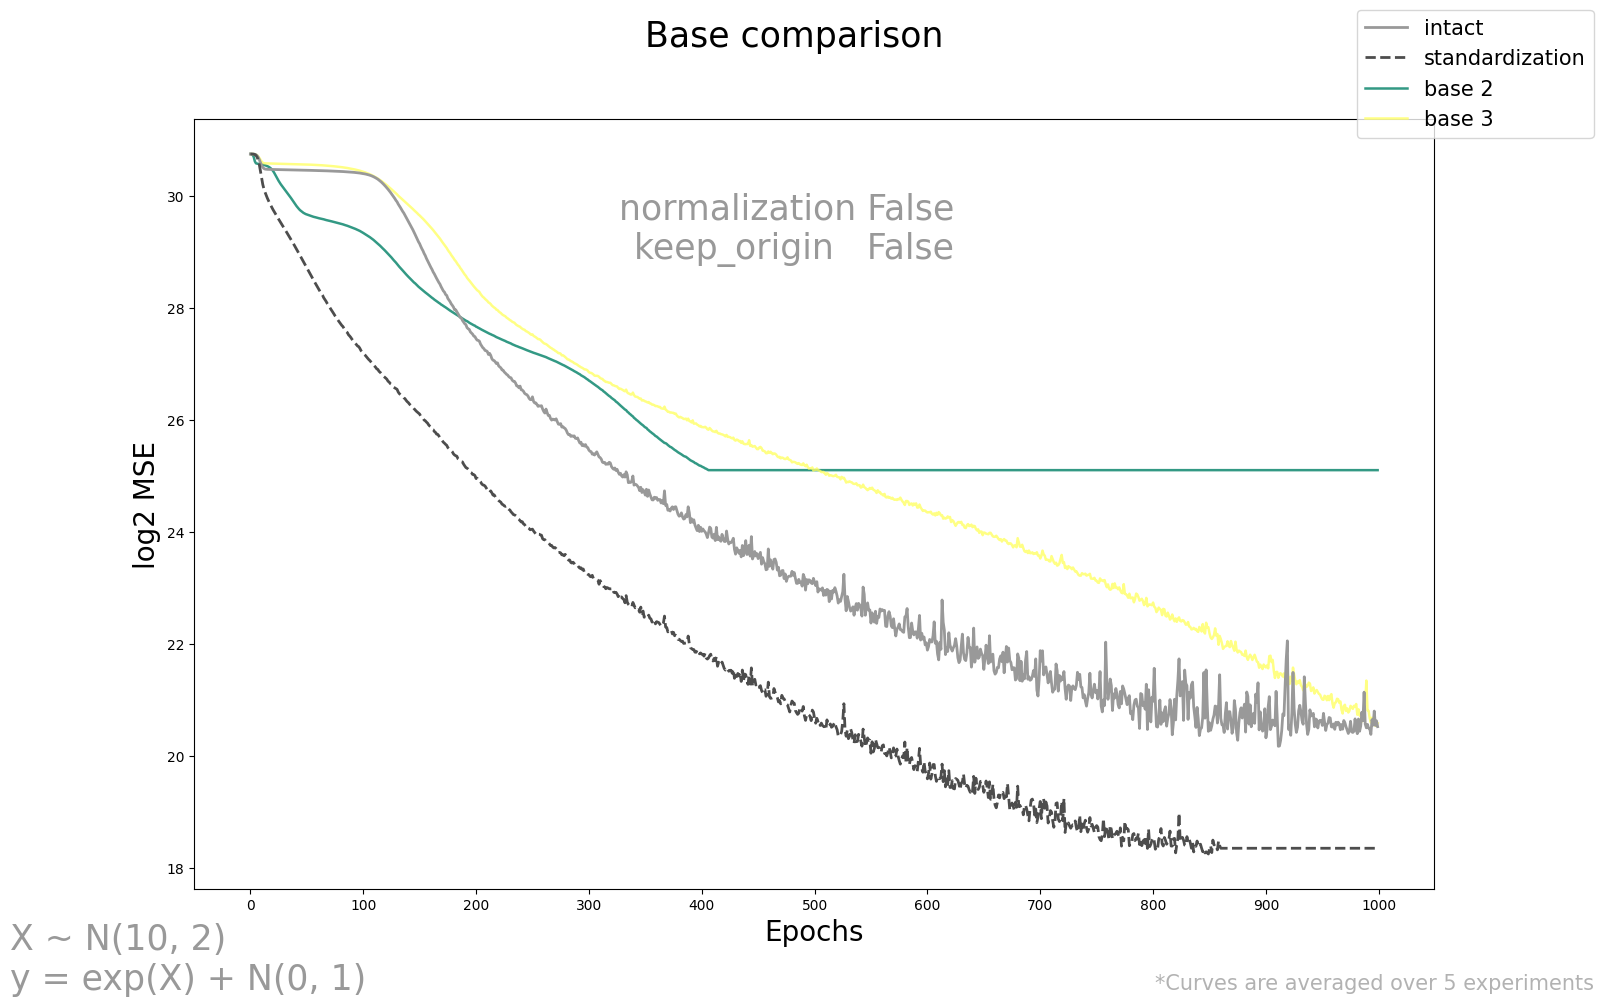

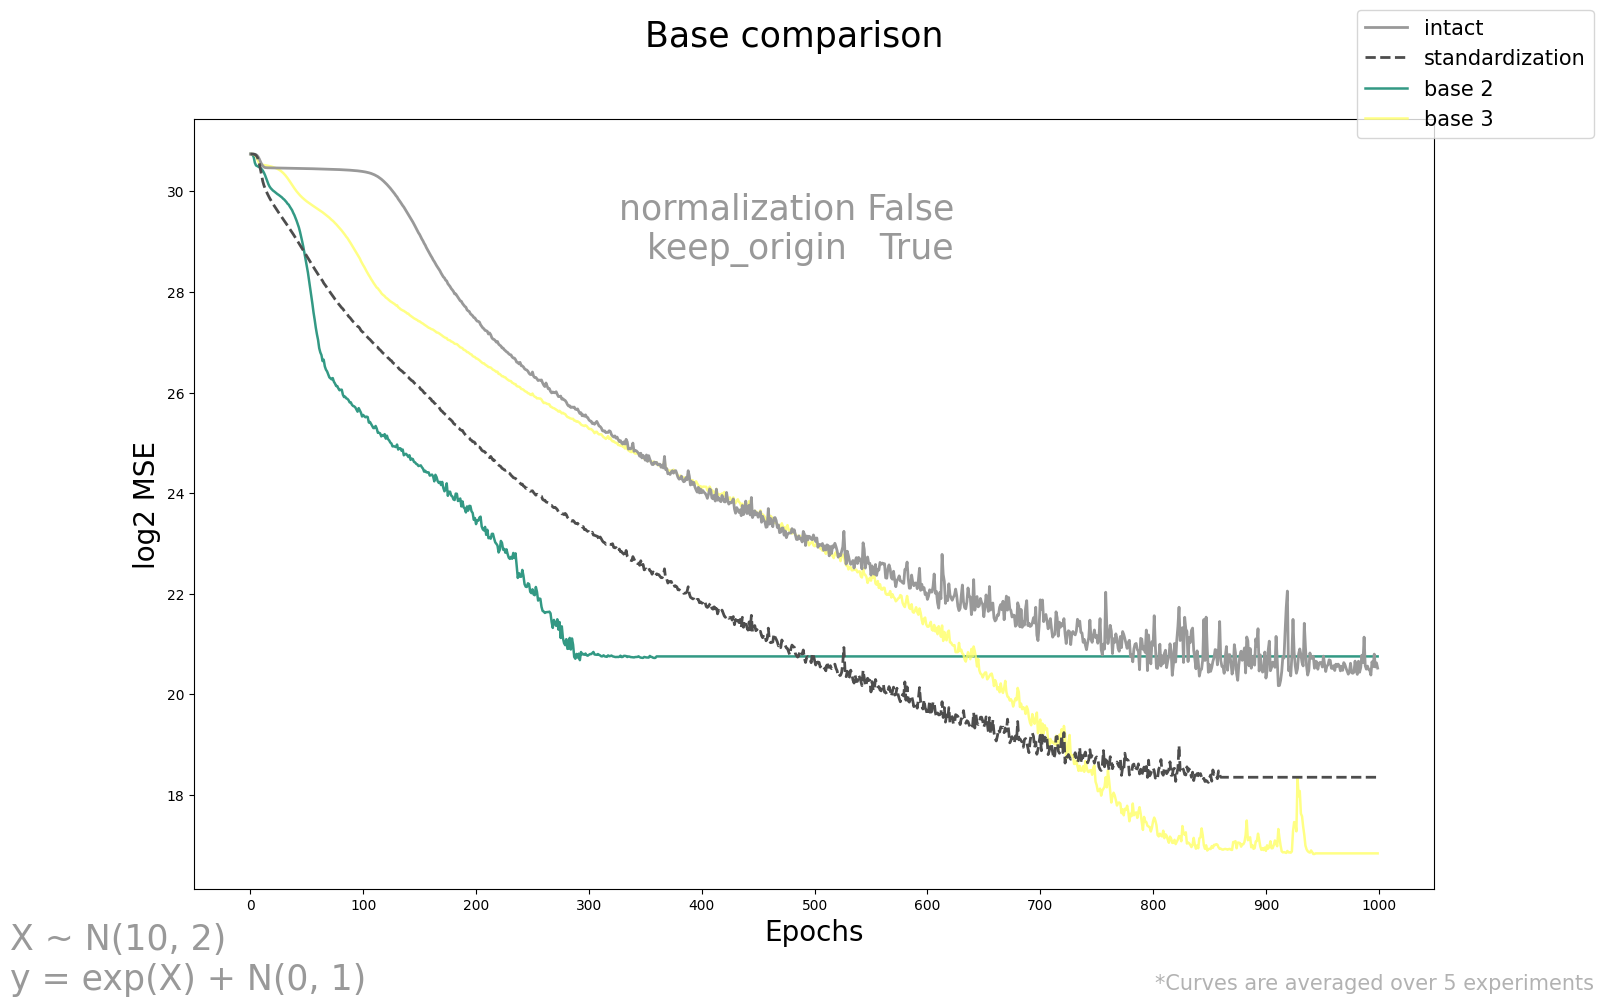

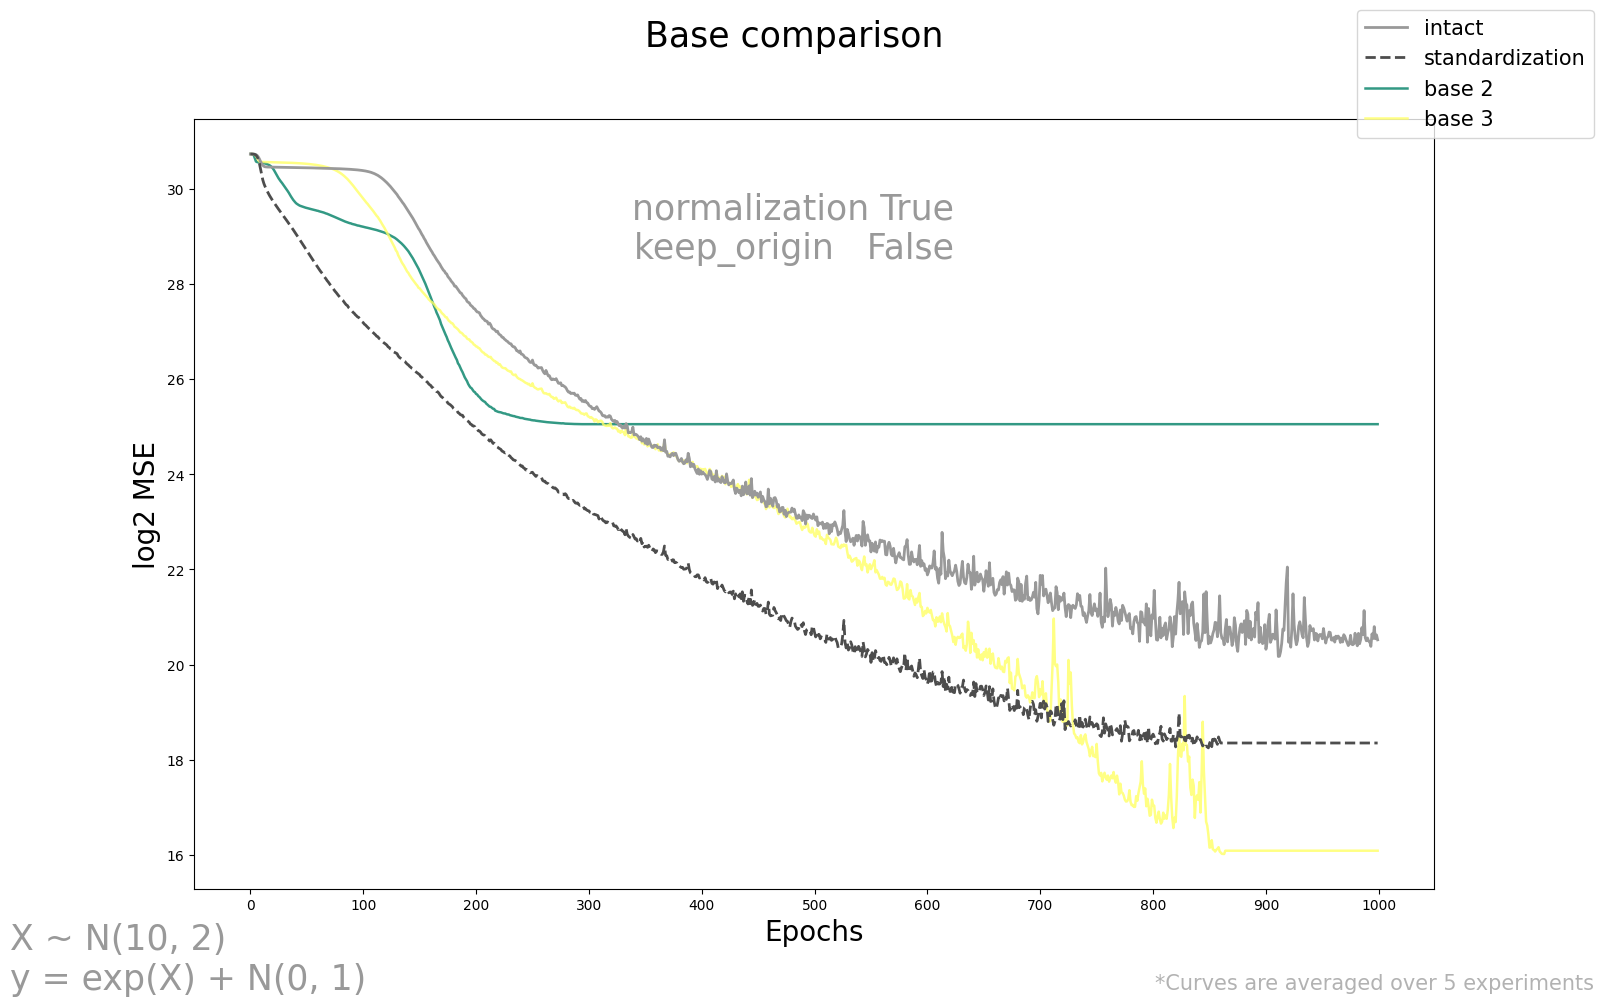

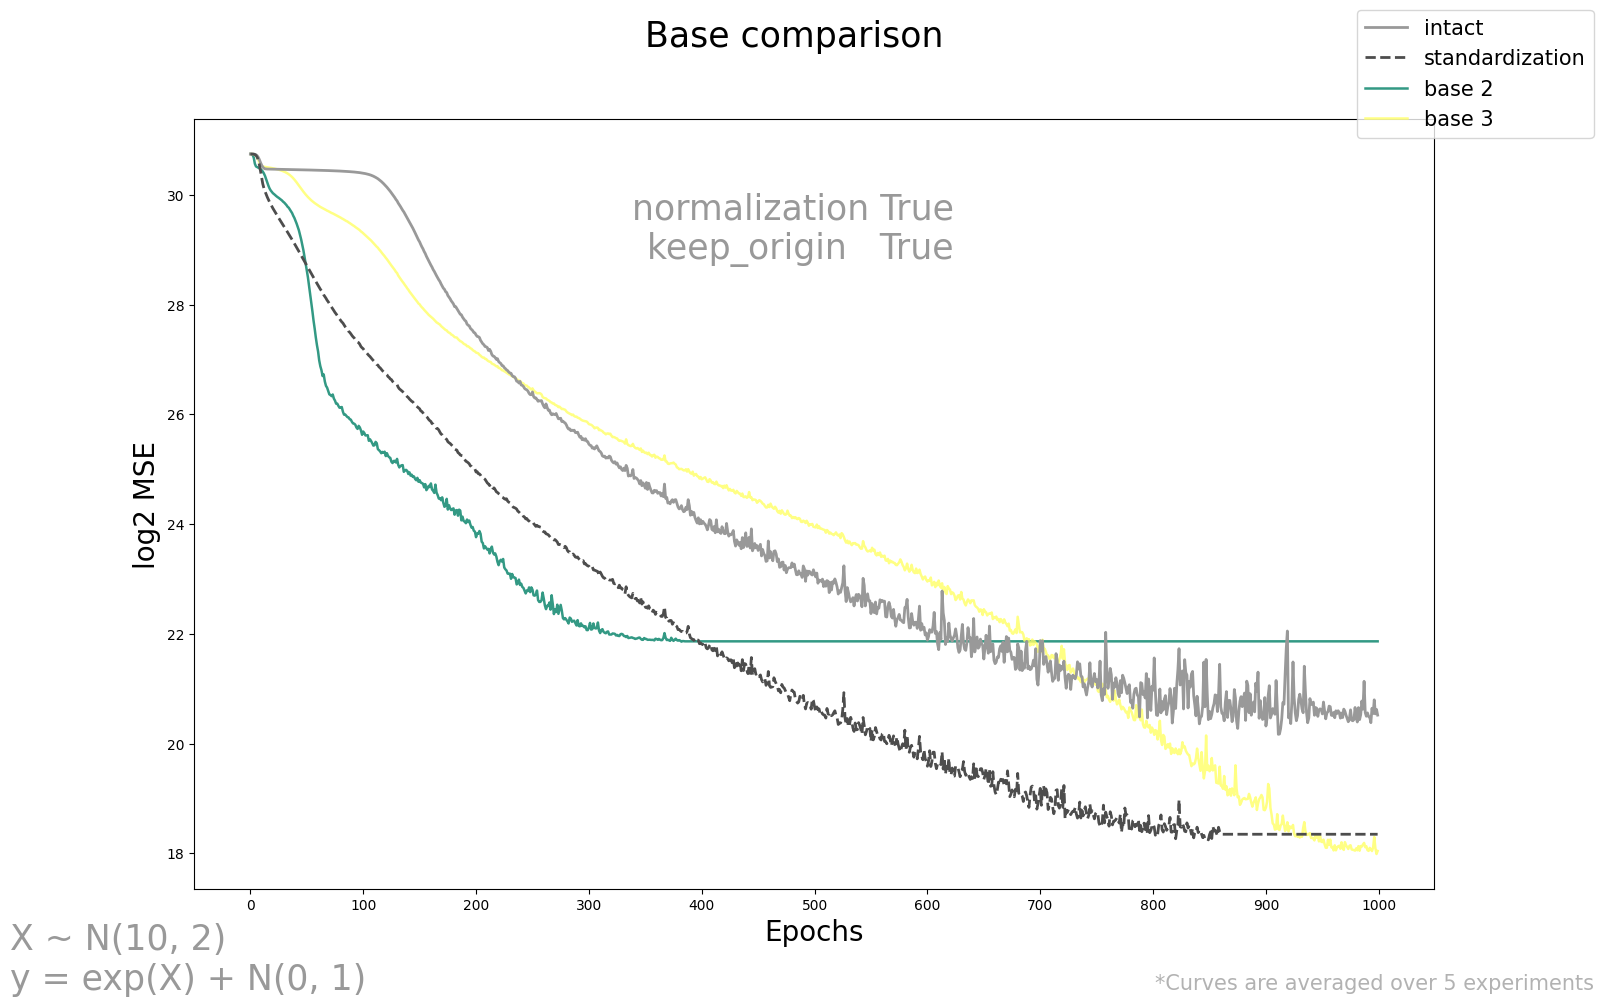

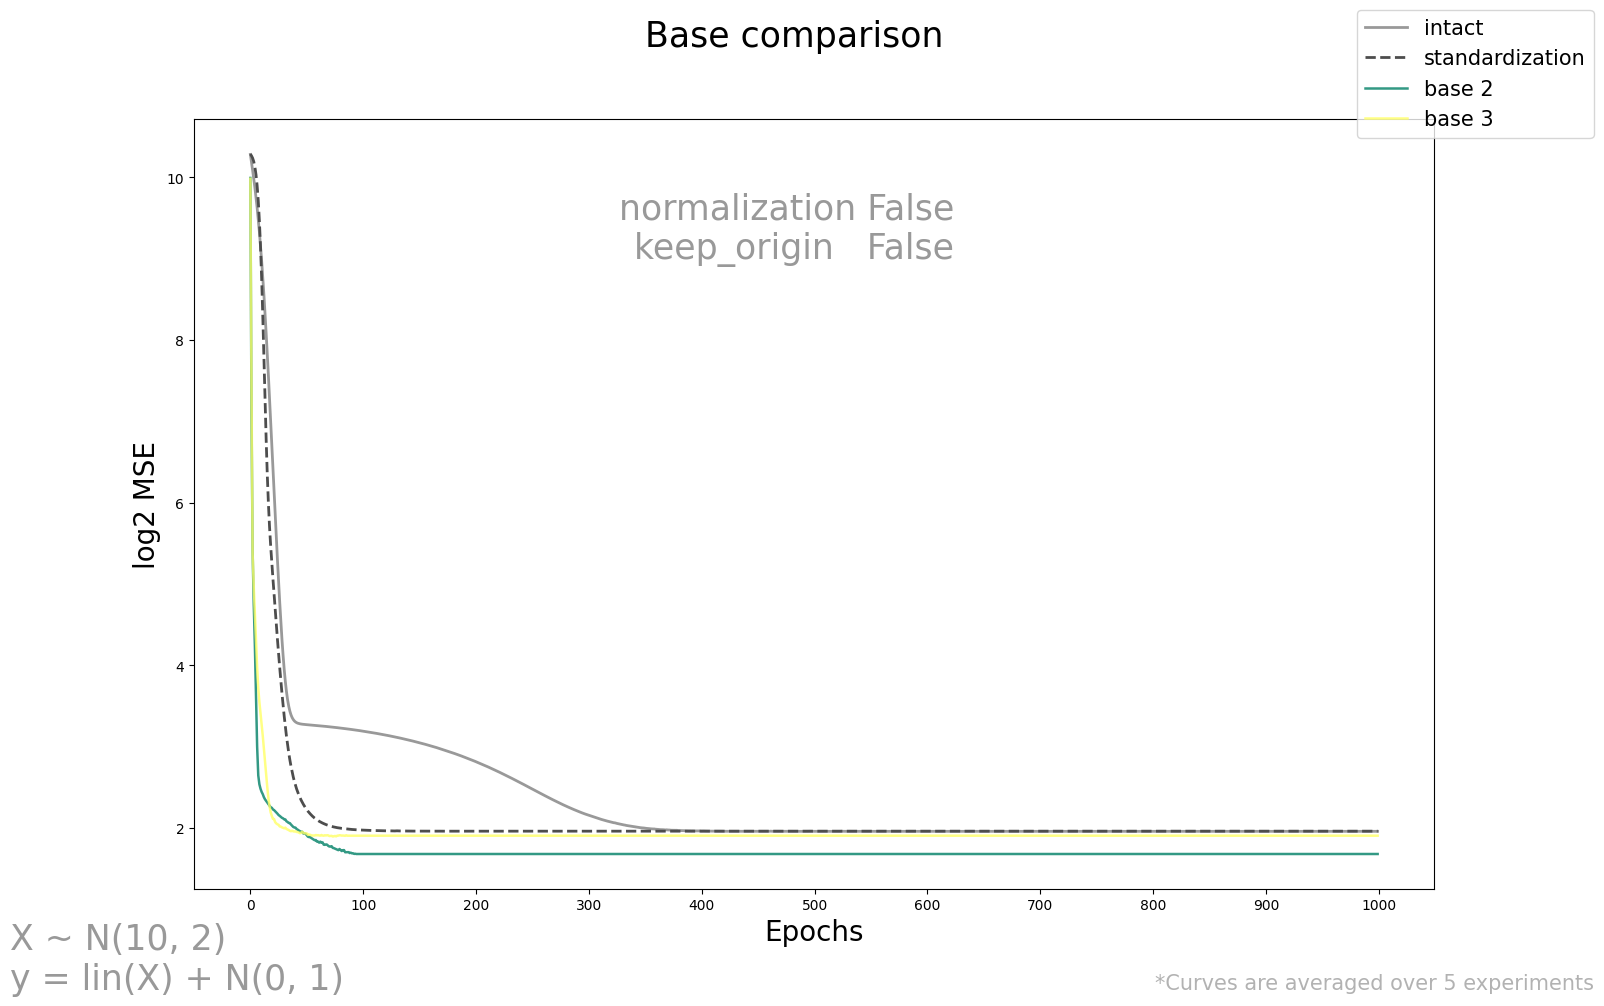

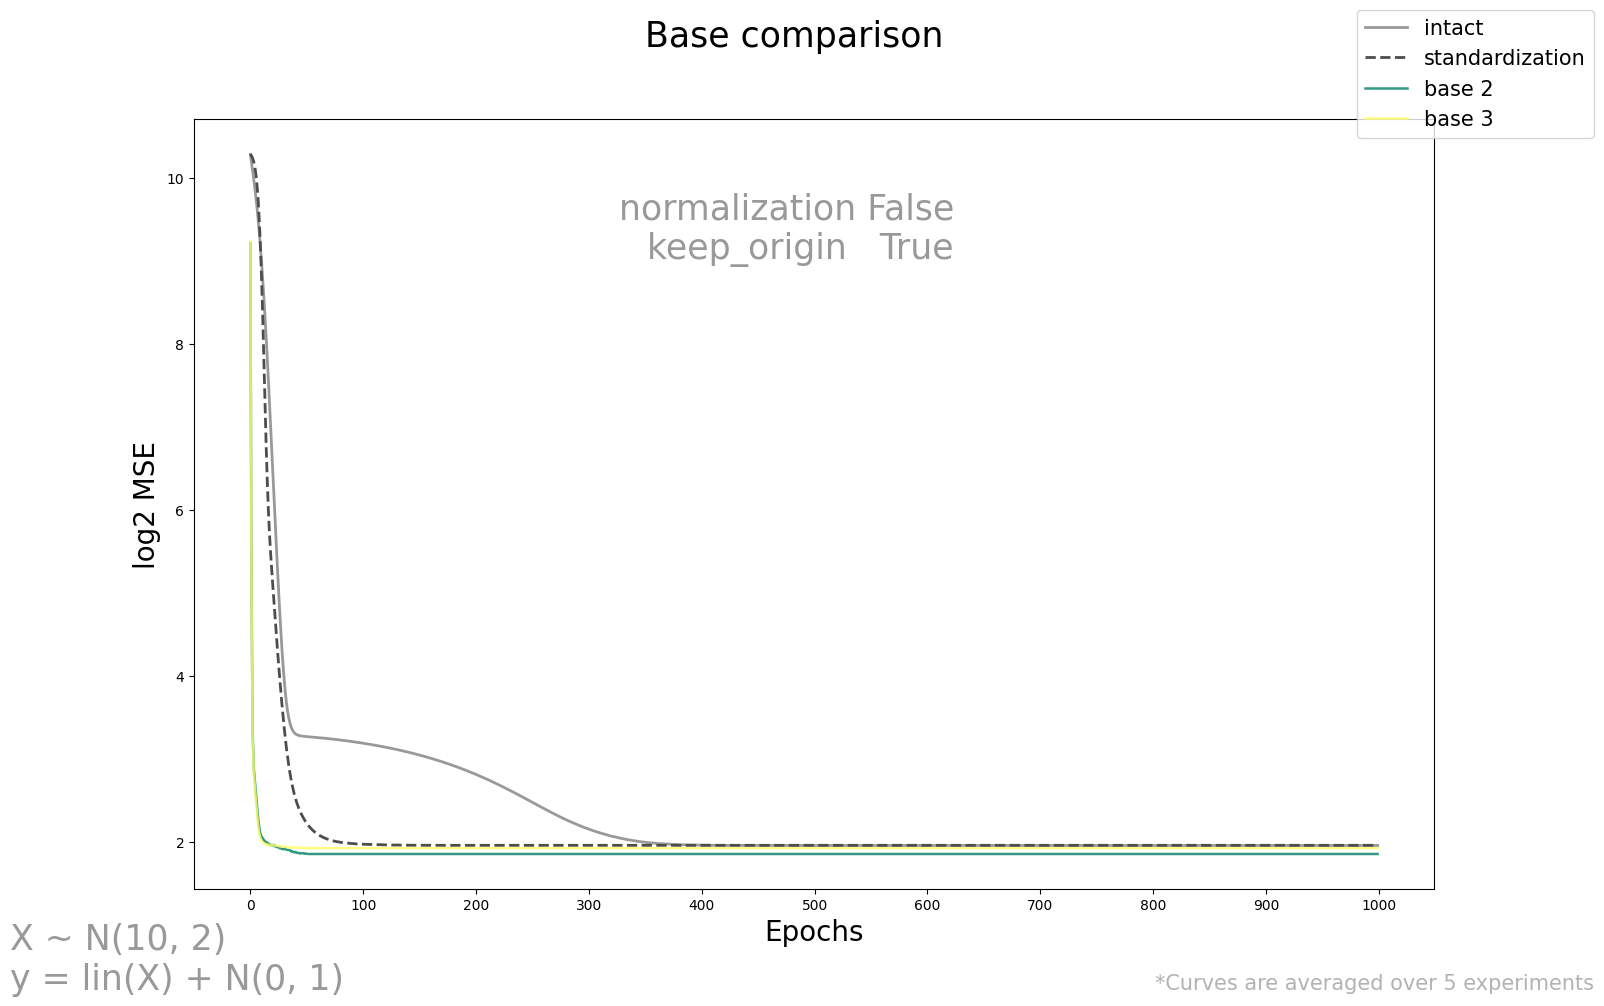

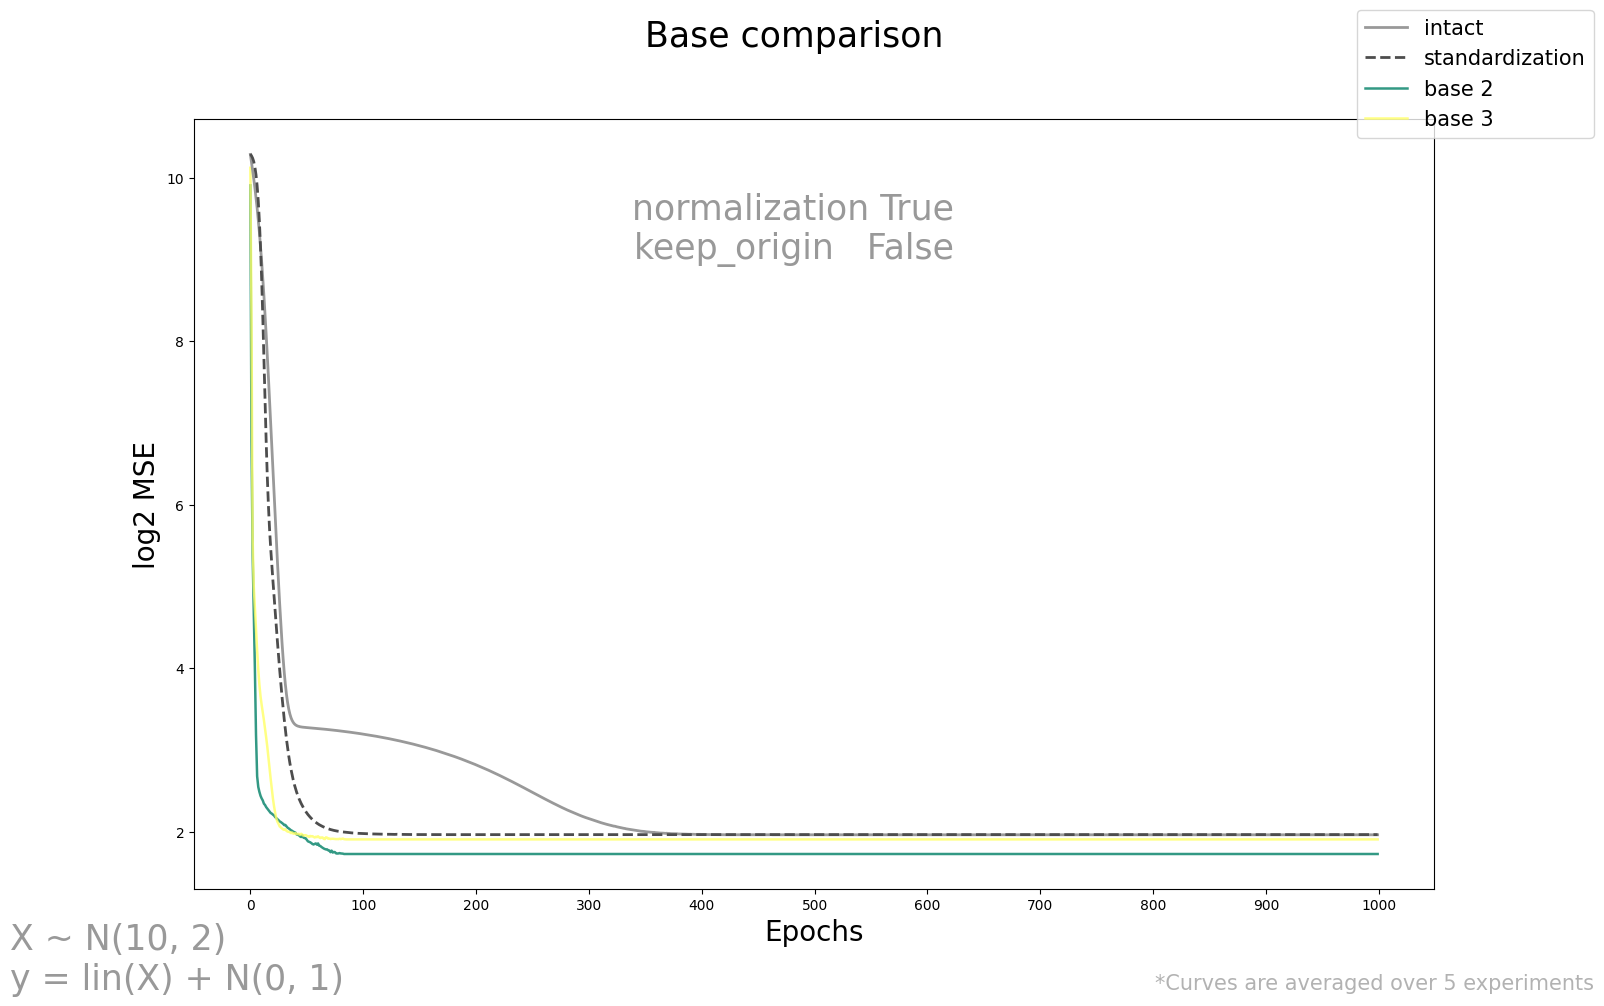

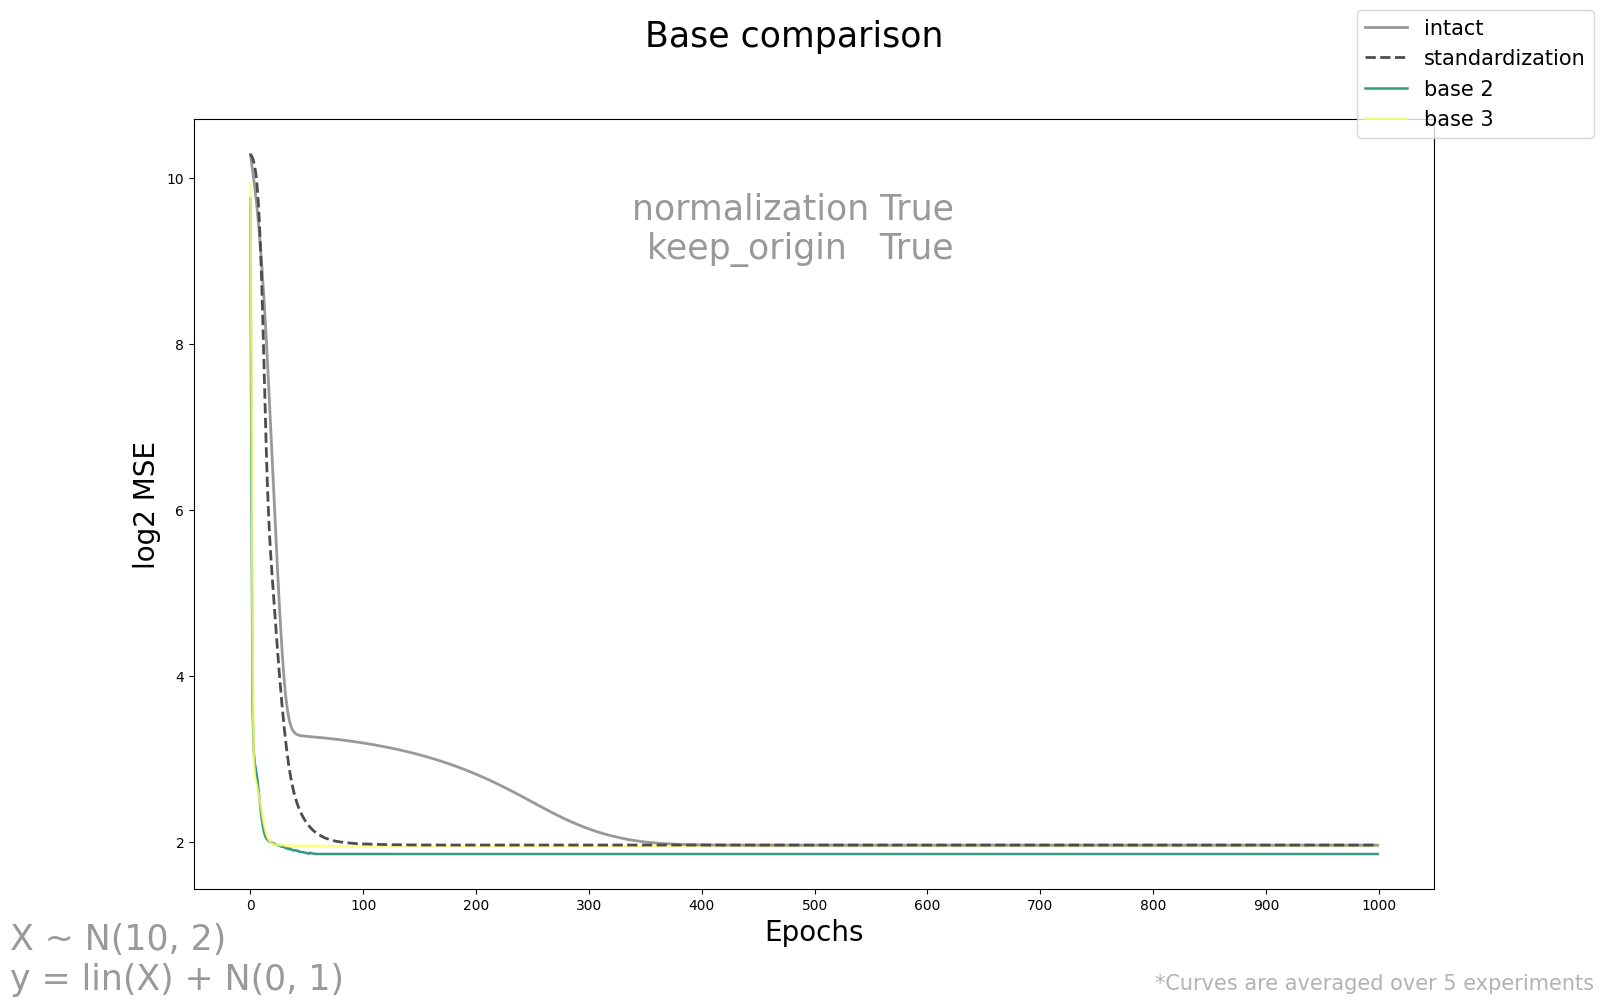

In [218]:
bools = [False, True]
linewidth = 2
baseline_step = 1
base_array = [2, 3]


for x, y in xy_arrays:
    mask = (df['x']==x)&(df['y']==y)
    ne = df[mask&(df['transformation_params.base']!=10)]
    intact = np.array(df[mask&(df['transformation_name']=="intact")]["history"].to_list())
    standardization = np.array(df[mask&(df['transformation_name']=="standardization")]["history"].to_list())
    
    baselines = {'intact':intact, 'standardization':standardization} 

    for norm in bools:
        for keep_origin in bools:
            fig, ax = plt.subplots(1, 1, figsize=(16,10))

            # Baseline plotting
            for (loss_name, loss), c, m in zip(baselines.items(), ['0.6', '0.3'], ['-', '--']):
                ax.plot(np.arange(constants.EPOCHS)[slice_from::baseline_step], func(loss.mean(axis=0)[slice_from::baseline_step]), m, c=c, label=loss_name, linewidth=linewidth, zorder=10)
            # Different bases
            color = iter(plt.cm.summer(np.linspace(0, 1, len(base_array))))

            for base in base_array:
                c = next(color)
                loss_0 = func(np.array(ne[(ne['transformation_params.base']==base)&(ne['transformation_params.norm']==norm)&(ne['transformation_params.keep_origin']==keep_origin)]['history'].to_list()).mean(axis=0)[slice_from:])
                ax.plot(loss_0, '-', label=f'base {base}',c=c, linewidth=linewidth-0.2, alpha=0.8)
                xticks = list(range(0, len(loss_0)+1, 100))
                ax.set_xticks(xticks, labels=list(range(slice_from, len(loss_0)+slice_from+1, 100)))

            plt.suptitle(f'Base comparison', size=25)
            fig.text(0.01, 0.01, f'X ~ {dist_names[x]}\n{y_funcs[y]}', alpha=0.4, size=25)               
            fig.text(1, 0.01, '*Curves are averaged over 5 experiments', alpha=0.3, size=15, ha='right')

            fig.text(0.6, 0.7, f'normalization {norm}\nkeep_origin   {keep_origin}\n', alpha=0.4, size=25, ha='right')               
            fig.legend(loc='upper right', prop={'size': 15})
            ax.set_ylabel(f"{func.__name__} MSE", size=20)
            ax.set_xlabel(f"Epochs", size=20)
            path = f"plots/x_{x}_y_{y}/base_comparison"
#             if not os.path.exists(path):
#                 os.mkdir(path)
#             plt.savefig(f'{path}/{norm}_{keep_origin}_{only_integers}.png')
#             plt.close()

# Distributions

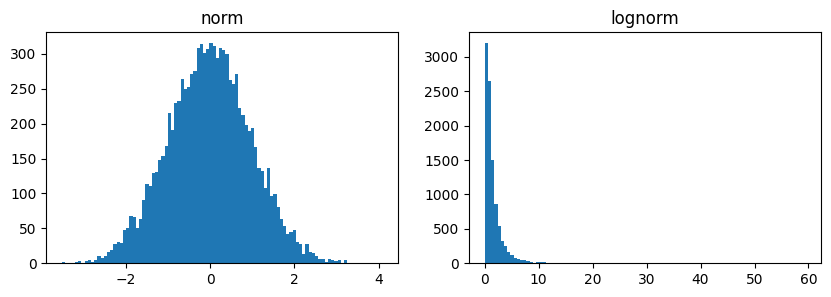

In [57]:
norm = distribution_data_sampler('norm', {'loc':0, 'scale':1}, n_samples, 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].hist(norm, bins=100)
ax[0].set_title('norm')
ax[1].hist(np.exp(norm), bins=100)
ax[1].set_title('lognorm')
plt.show()

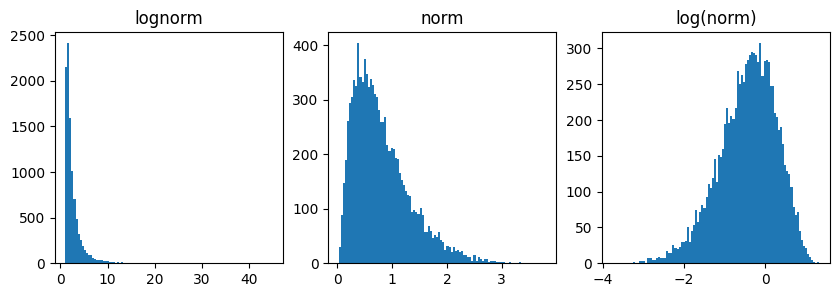

In [58]:
lognorm = distribution_data_sampler('lognorm', {'loc':1, 'scale':1, 's':1}, n_samples, 1)
# lognorm = np.exp(norm)
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].hist(lognorm, bins=100)
ax[0].set_title('lognorm')
ax[1].hist(np.log(lognorm), bins=100)
ax[1].set_title('norm')
ax[2].hist(np.log(np.log(lognorm)), bins=100)
ax[2].set_title('log(norm)')
plt.show()

In [59]:
be_layer = BaseEncoder()

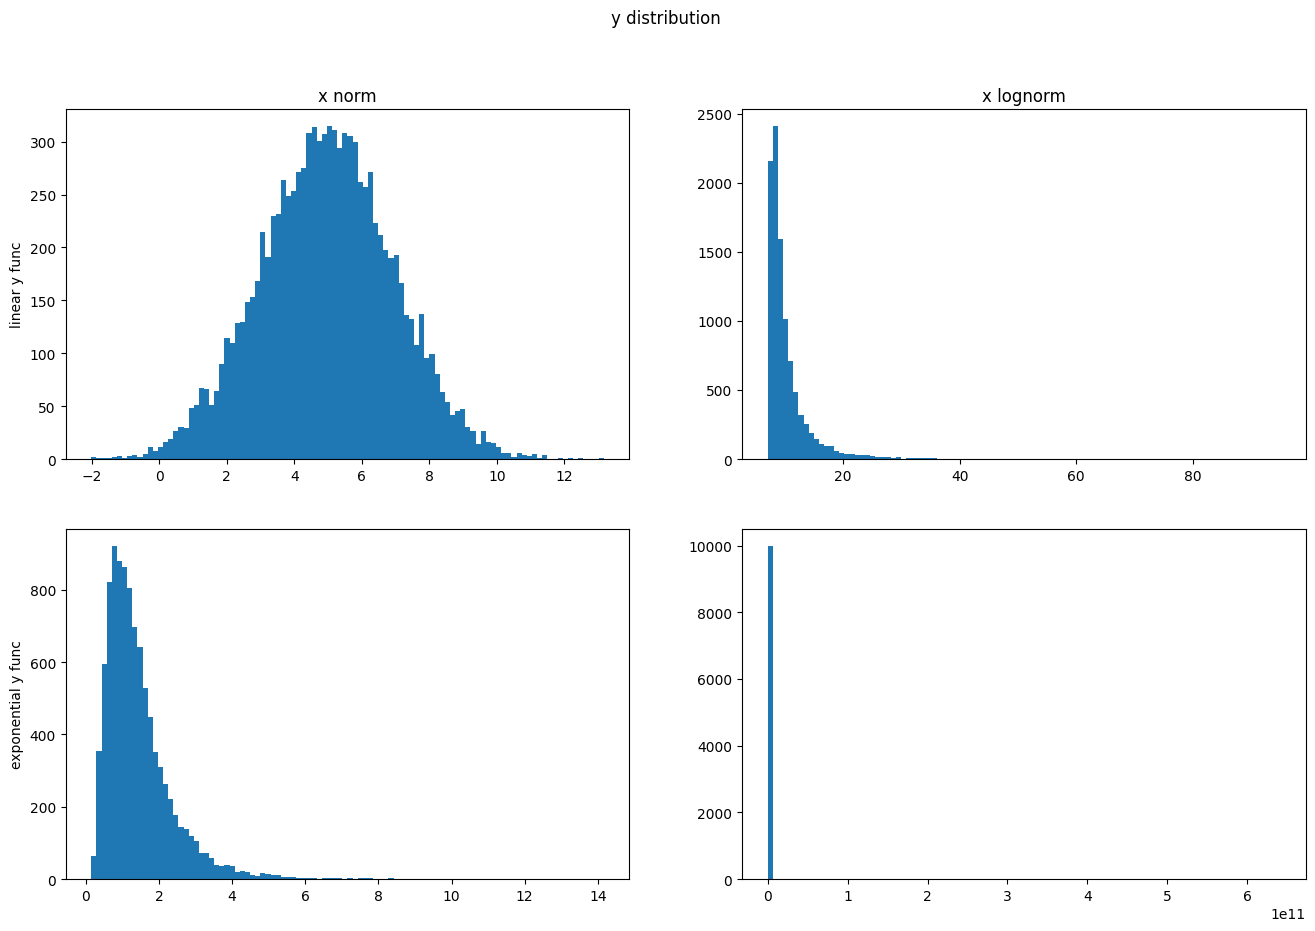

In [60]:
noise = stats.norm.rvs(size=(n_samples, 1), loc=0, scale=0.5)
lin_func = lambda x, a=2, b=5: a*x + b
exp_func = lambda x, a=0.6, b=0.2: np.exp(a*x + b)

fig, ax = plt.subplots(2, 2, figsize=(16, 10))
for idx, x in enumerate([norm, lognorm]):
    for idy, y_func in enumerate([lin_func, exp_func]):
        ax[idy, idx].hist(y_func(x), bins=100)
        
ax[0, 0].set_title('x norm')
ax[0, 1].set_title('x lognorm')

ax[0, 0].set_ylabel('linear y func')
ax[1, 0].set_ylabel('exponential y func')

plt.suptitle('y distribution')
plt.show()

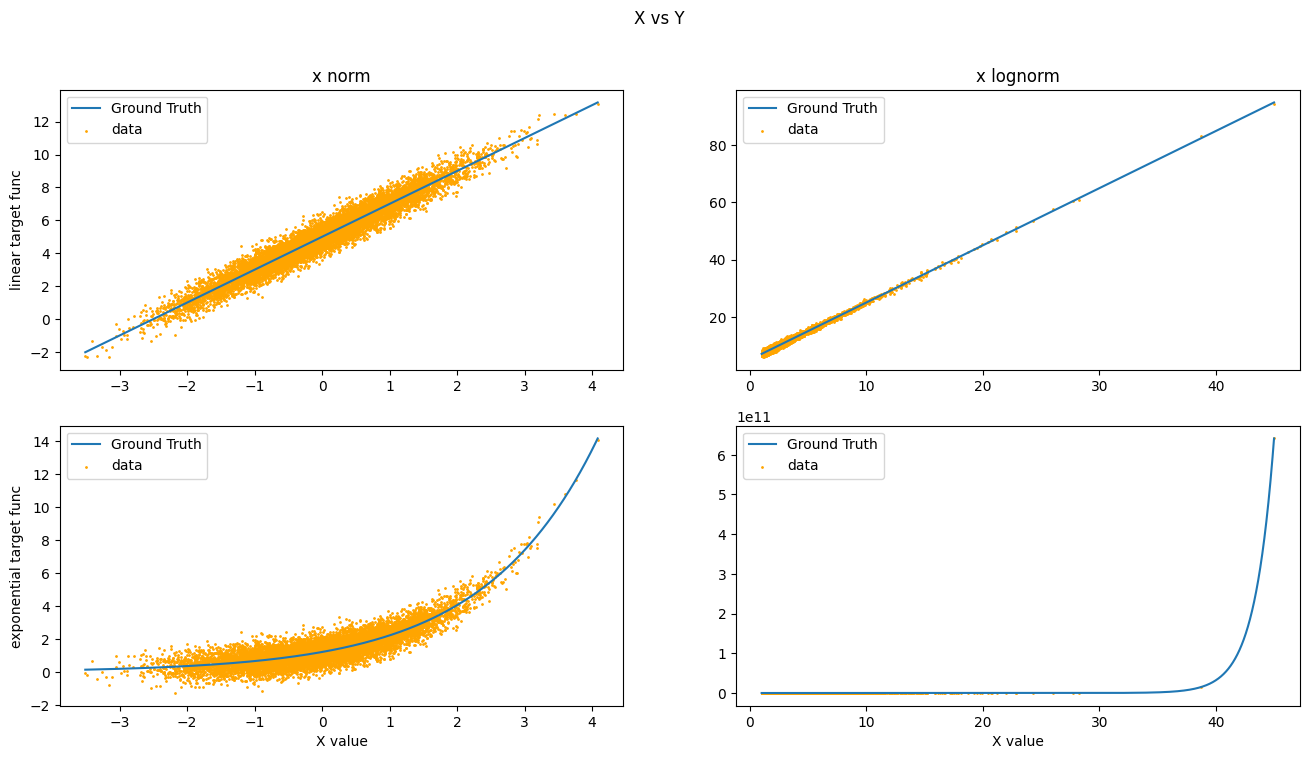

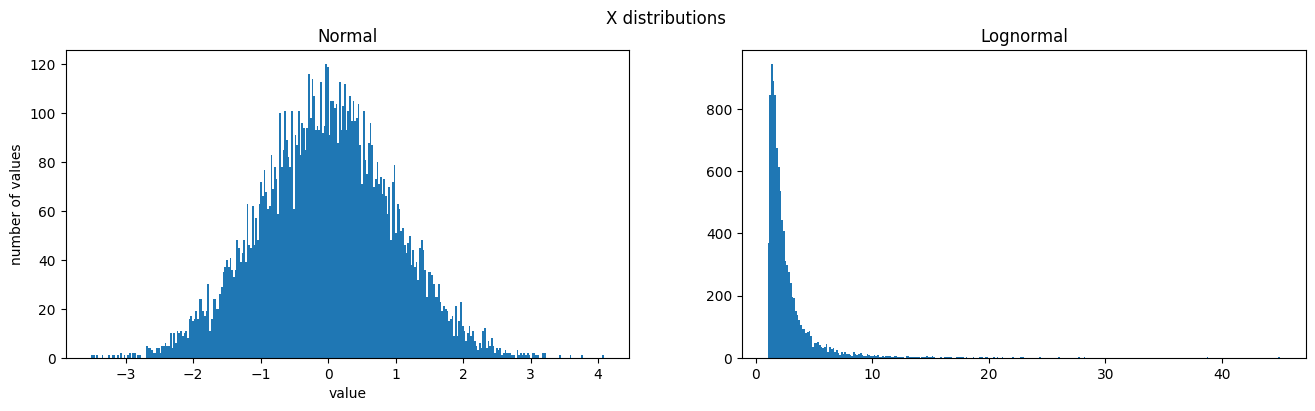

In [66]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
for idx, func_name in enumerate(['lin_func', 'exp_func']):
    for idy, x_name in enumerate(['norm', 'lognorm']):
        func = eval(func_name)
        x = eval(x_name)
        ground_truth_x = np.linspace(x.min(), x.max(), n_samples)
        ax[idx, idy].plot(ground_truth_x, func(ground_truth_x), label='Ground Truth')
        ax[idx, idy].scatter(x, func(x) + noise, s=1, c='orange', label='data')
        ax[idx, idy].legend()

ax[0, 0].set_title('x norm')
ax[0, 1].set_title('x lognorm')
ax[0, 0].set_ylabel('linear target func')
ax[1, 0].set_xlabel('X value')
ax[1, 1].set_xlabel('X value')

ax[1, 0].set_ylabel('exponential target func')
fig.suptitle('X vs Y')
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('X distributions')
ax[0].hist(norm, bins=300)
ax[1].hist(lognorm, bins=300)
ax[0].set_ylabel('number of values')
ax[0].set_xlabel('value')
ax[0].set_xlabel('value')
ax[0].set_title('Normal')
ax[1].set_title('Lognormal')

plt.show()

# Loss function

In [5]:
y = np.array([8, 8, 8, 8, 8, 8, 8, 8, 
              32, 32, 32, 32, 32, 32, 32, 32,
              512, 512, 512, 512, 512, 512, 512, 512]).reshape(-1, 1)

y_hat = np.array([8, 16, -8, -16, 8.125, 16.25, -8.125, -16.25,
                  32, 64, -32, -64, 32.5, 65, -32.5, -65, 
                  512, 1024, -512, -1024, 520, 1040, -520, -1040]).reshape(-1, 1)


# y = np.array([1, 2, 4, 8, 16]).reshape(-1, 1)

# y_hat = np.array([0.5, 1, 2, 4, 8]).reshape(-1, 1)

be_layer = BaseEncoder()

y_be = be_layer(y).numpy()
y_hat_be = be_layer(y_hat).numpy()
y_hat_be_raw = y_hat_be.copy()
np.set_printoptions(suppress=True)
np.place(y_hat_be, y_hat_be == 1, 0.999999)
np.place(y_hat_be, y_hat_be == 0, 0.000001)

In [52]:
def bce(y_be, y_hat):
    return np.multiply(y_be, np.log(y_hat)) + np.multiply(1 - y_be, np.log(1 - y_hat))

In [77]:
def bece_func(y_be, y_hat, y_sign, y_hat_sign):
    y_sign = np.multiply(np.ones(y_be.shape), y_sign)
    y_hat_sign = np.multiply(np.ones(y_hat.shape), y_hat_sign)

    neg_one = np.multiply(np.multiply(y_be, y_sign), np.log(np.multiply(y_hat, y_hat_sign)))
    pos_one = np.multiply(np.multiply(y_be, (1 - y_sign)), np.log(np.multiply(y_hat,(1 - y_hat_sign))))
##################### do not uncomment - it makes the loss equally disregard of its value 
##################### loss(512, -512)= loss(8, -8)
#     neg_zero = np.multiply(np.multiply(1 - y_be, y_sign), np.log(np.multiply(1 - y_hat, y_hat_sign)))
#     pos_zero = np.multiply(np.multiply(1 - y_be, (1 - y_sign)), np.log(np.multiply(1 - y_hat,(1 - y_hat_sign))))
#     return -(neg_zero + pos_zero + neg_one + pos_one)
#####################
    zeros = np.multiply(1 - y_be, np.log(1 - y_hat))
    return -(zeros + neg_one + pos_one)


In [78]:
def preprocess(y, y_hat):
    be_layer = BaseEncoder()

    y_be = be_layer(y).numpy()
    y_hat_be = be_layer(y_hat).numpy()

    np.place(y_hat_be, y_hat_be == 1, 0.999999)
    np.place(y_hat_be, y_hat_be == 0, 0.000001)
    
    return y_be, y_hat_be

In [79]:
def new_loss_func(y, y_hat):
    y_mant = y[:, :, 9:]
    y_exp = y[:, :, 1:9]
    y_sign = y[:, :, :1]


    y_hat_mant = y_hat[:, :, 9:]
    y_hat_exp = y_hat[:, :, 1:9]
    y_hat_sign = y_hat[:, :, :1]
    
    mantissa_coefs = (np.ones((y_mant.shape[0], y_mant.shape[1], 1))*2)**((np.arange(-11, 12)[::-1]).reshape(1, -1))
    mantissa_bce = bce(y_mant, y_hat_mant)
    mantissa_part = (1 + np.multiply(mantissa_coefs, mantissa_bece)).sum(axis=-1)


    exponent_coefs = (np.ones((y_exp.shape[0], y_exp.shape[1], 1))*2)**((np.arange(1, 9))[::-1].reshape(1, -1))
    exponent_bece = bece_func(y_exp, y_hat_exp, y_sign, y_hat_sign)
    exponent_part = np.multiply(exponent_coefs, exponent_bece).sum(axis=-1) 
    

In [80]:
y_mant = y_be[:, :, 9:]
y_hat_mant = y_hat_be[:, :, 9:]

y_sign = y_be[:, :, :1]
y_hat_sign = y_hat_be[:, :, :1]

In [81]:
mantissa_bece = bce(y_mant, y_hat_mant)
mantissa_coefs = (np.ones((y_mant.shape[0], y_mant.shape[1], 1))*2)**-((np.arange(1, 24)[::-1]).reshape(1, -1))
mantissa_part = (1 - np.multiply(mantissa_bece, mantissa_coefs).sum(axis=-1))

In [82]:
y_exp = y_be[:, :, 1:9]
y_hat_exp = y_hat_be[:, :, 1:9]

In [83]:
exponent_coefs = (np.ones((y_exp.shape[0], y_exp.shape[1], 1))*2)**((np.arange(1, 9))[::-1].reshape(1, -1))
exponent_bce = bece_func(y_exp, y_hat_exp, y_sign, y_hat_sign)
exponent_part = np.multiply(exponent_coefs, exponent_bce).sum(axis=-1) 

In [84]:
new_loss = np.log2(exponent_part) + np.log2(mantissa_part)

In [85]:
def loss_func(y, y_hat):
    
    y_mant = y[:, :, 9:]
    y_exp = y[:, :, 1:9]
    y_sign = y[:, :, :1]


    y_hat_mant = y_hat[:, :, 9:]
    y_hat_exp = y_hat[:, :, 1:9]
    y_hat_sign = y_hat[:, :, :1]
    
    
#     mantissa_coefs = (np.ones((y_mant.shape[0], y_mant.shape[1], 1))*2)**-((np.arange(0, 23)).reshape(1, -1))
    mantissa_coefs = (np.ones((y_mant.shape[0], y_mant.shape[1], 1))*2)**((np.arange(-11, 12)[::-1]).reshape(1, -1))
    mantissa_bece = bece_func(y_mant, y_hat_mant, y_sign, y_hat_sign)
    mantissa_part = np.log2(np.multiply(mantissa_coefs, mantissa_bece).sum(axis=-1))
#     mantissa_part = (1 + np.multiply(mantissa_coefs, mantissa_bece)).sum(axis=-1)


    exponent_coefs = (np.ones((y_exp.shape[0], y_exp.shape[1], 1))*2)**((np.arange(1, 9))[::-1].reshape(1, -1))
    exponent_bece = bece_func(y_exp, y_hat_exp, y_sign, y_hat_sign)
    exponent_part = np.multiply(exponent_coefs, exponent_bece).sum(axis=-1) 
    
    return exponent_part, mantissa_part 

In [86]:
# exponent_part, mantissa_part = loss_func(y_be, y_hat_be)
# final_loss = exponent_part + mantissa_part
df = pd.DataFrame(np.concatenate((y, y_hat, (np.abs(y_be - y_hat_be_raw)).sum(axis=-1),((y - y_hat)**2).astype(np.float32), exponent_part, mantissa_part, new_loss), axis=-1), 
             columns=['y', 'y_hat', 'binary diff number', 'mse', 'exponent part', 'mantissa part', 'new loss'])

NameError: name 'y' is not defined

In [1]:
# df.sort_values("new loss")

In [2]:
# df.sort_values("final loss")